In [1]:
# Add the parent directory to the path so that we can import the necessary modules
import sys
sys.path.append('../')

In [2]:
#export
# imports
import torch
import math
from torchsparse.utils.quantize import sparse_quantize
from torchsparse import SparseTensor
from torchsparse.utils.collate import sparse_collate_fn
from abc import abstractmethod
from models.sparse_utils import batch_sparse_quantize_torch

In [3]:
import time
from functools import partial
from utils.visualization import quick_vis_batch
vis_batch = partial(quick_vis_batch, x_offset = 8, y_offset=8)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Load a trained model

In [ ]:
from models.ddpm_unet import SPVUnet

In [ ]:
model = SPVUnet(voxel_size=0.1, nfs=(32, 64, 128, 256), num_layers=1, pres=1e-5)
model.pres

In [ ]:
#ckpt_path = '/home/tourloid/Desktop/PhD/Code/SPVD/checkpoints/spvcnn_0.1_32_64_128_256_constant_lr_Dropout_300.pt'
#ckpt_path = '/home/vvrbeast/Desktop/Giannis/Code/TransformerDiffusion/checkpoints/spvcnn_0.1_32_64_128_256_constant_lr_1900.pt'
#model.load_state_dict(torch.load(ckpt_path)['state_dict'])

In [ ]:
model = model.cuda().eval()

# Create Scheduler

In [ ]:
class SchedulerBase:

    def __init__(self, beta_min=0.0001, beta_max=0.02, n_steps=1000, mode='linear'):

        self.beta_min, self.beta_max, self.n_steps = beta_min, beta_max, n_steps

        if mode == 'linear':
            self.inds, self.beta, self.alpha, self.alpha_hat = self._linear_scheduling()
        else: 
            raise NotImplementedError
        

    def _linear_scheduling(self):

        inds = torch.arange(self.n_steps)
        beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        alpha = 1. - beta
        alpha_hat = torch.cumprod(alpha, dim=0)
        
        return inds, beta, alpha, alpha_hat

    def get_pc(self, x_t, shape):
        # this functions receives x_t as used by the pipeline returns a cpu tensor
        return x_t.detach().cpu().reshape(shape)
        
    @torch.no_grad()
    def sample(self, model, bs, n_points=2048, nf=3, emb=None, save_process=False):
        """
            Args:
                - model        : neural net for noise prediction
                - bs           : number of samples to generate
                - n_points     : number of points per point cloud
                - nf           : number of features - default 3 for xyz coordinates
                - emb          : conditional embedding, if None it will be ignored
                - save_process : save the intermediate point clouds of the generation process
        """
        device = next(model.parameters()).device
        shape = (bs, n_points, nf)

        x_t = self.create_noise(shape, device)
        preds = [self.get_pc(x_t, shape)] 

        for i, t in enumerate(reversed(self.inds)):
            x_t = self.sample_step(model, x_t, t, i, emb, shape, device)
            if save_process: preds.append(self.get_pc(x_t, shape)) 

        return preds if save_process else self.get_pc(x_t, shape)


    def sample_step(self, model, x_t, t, i, emb, shape, device):
        """
            Args:
                - model  : neural net for noise prediction
                - x_t    : previous point cloud
                - t      : current time step
                - i      : denoising iteration
                - emb    : conditional embedding, if None it will be ignored
                - shape  : shape of the point cloud
                - device : device to run the computations
        """
        bs = shape[0]

        # creating the time embedding variable
        t_batch = torch.full((bs,), t, device=device, dtype=torch.long)

        # activate the model to predict the noise
        noise_pred = model((x_t, t_batch)) if emb is None else model((x_t, t_batch, emb))
        
        # calculate the new point coordinates
        x_t = self.update_rule(x_t, noise_pred, t, i, shape, device)
        
        return x_t

    def create_noise(self, shape, device):
        return torch.randn(shape).to(device)

    @abstractmethod
    def predict_x0_from_noise(self, x_t, noise_pred, t, shape, device):
        # x_t.shape : B x N x F
        # noise_pred.shape : B x N x F
        pass
    
    @abstractmethod
    def update_rule(self, x_t, noise_pred, t, shape, device):
        # x_t.shape : B x N x F
        # noise_pred.shape : B x N x F
        pass

    @abstractmethod
    def noisify_sample(self, x0, step):
        pass

In [ ]:
class SparseScheduler(SchedulerBase):

    def __init__(self, beta_min=0.0001, beta_max=0.02, n_steps=1000, mode='linear', pres=1e-5):
        super().__init__(beta_min, beta_max, n_steps, mode)
        self.pres = pres
    
    def create_noise(self, shape, device):
        noise = torch.randn(shape)
        noise = self.torch2sparse(noise, shape).to(device)
        return noise

    def get_pc(self, x_t, shape):
        
        # this functions receives x_t as used by the pipeline returns a cpu tensor
        return x_t.F.detach().cpu().reshape(shape)

    def update_rule(self, x_t, noise_pred, t, i, shape, device):
        # outside the update_rule the point cloud is represented as SparseTensor
        x_t = x_t.F
        x_t = self._update_rule(x_t, noise_pred, t, i, shape, device)
        # return a SparseTensor
        return self.torch2sparse(x_t, shape).to(device)
        
    @abstractmethod
    def _update_rule(self, x_t, noise_pred, t, shape, device):
        pass
        
    
    @abstractmethod
    def torch2sparse(self, pts:torch.Tensor, shape):
        # Receive a torch.Tensor of shape BxNxF and returns a SparseTensor representation
        pass
    

In [ ]:
class SparseSchedulerCPU(SparseScheduler):

    def torch2sparse(self, pts:torch.Tensor, shape):
        # Receive a torch.Tensor of shape BxNxF and returns a SparseTensor representation
        pts = pts.cpu().reshape(shape) # make sure points have the correct shape
        
        # make coordinates positive
        coords = pts[:, :, :3]
        coords = coords - coords.min(dim=1, keepdim=True)[0]
        coords = coords.numpy()

        # Unfortunately we need to loop over the batch to apply sparse_quantize 
        # Also DATA have to be in CPU and coords represented as np.arrays
        batch = []
        for b in range(shape[0]):

            c, indices = sparse_quantize(coords[b], self.pres, return_index=True)
            f = pts[b][indices]

            batch.append(
                {'pc':SparseTensor(coords = torch.tensor(c), feats=f)}
            )
        
        batch = sparse_collate_fn(batch)['pc']

        return batch

In [ ]:
class DDPMScheduler(SparseScheduler):

    def __init__(self, beta_min=0.0001, beta_max=0.02, n_steps=1000, pres=1e-5, mode='linear', sigma='bt'):
        super().__init__(beta_min, beta_max, n_steps, mode)
        self.pres = pres

        assert sigma in ['bt', 'coef_bt'], sigma
        if sigma == 'bt':
            self.sigma = self.beta.sqrt()
        else:
            alpha_hat_prev1 = torch.ones_like(self.alpha_hat)
            alpha_hat_prev1[1:] = self.alpha_hat[:-1]
            self.sigma = torch.sqrt(self.beta * (1 - alpha_hat_prev1) / (1 - self.alpha_hat))
    
    def _update_rule(self, x_t, noise_pred, t, i, shape, device):

        # create normal noise with the same shape as x_t
        z = torch.randn(x_t.shape).to(device)
        
        # get parameters for the current timestep
        a_t, ahat_t, s_t = self.alpha[t], self.alpha_hat[t], self.sigma[t]
        
        x_t = 1 / math.sqrt(a_t) * (x_t - (1 - a_t) / (math.sqrt(1 - ahat_t)) * noise_pred) + s_t * z

        return x_t

In [ ]:
class DDPMSparseSchedulerCPU(DDPMScheduler, SparseSchedulerCPU):
    pass

In [ ]:
sched = DDPMSparseSchedulerCPU(sigma='coef_bt')

In [ ]:
t_start = time.time()
preds = sched.sample(model, 32)
t_end = time.time()
print(f"Generation time of {1} sample {t_end-t_start} sec")

In [ ]:
vis_batch(preds)

# Generation on GPU

In [ ]:
class SparseSchedulerGPU(SparseScheduler):

    def torch2sparse(self, pts:torch.Tensor, shape):
        pts = pts.reshape(shape)
        
        coords = pts[..., :3] # In case points have additional features
        coords = coords - coords.min(dim=1, keepdim=True).values
        coords, indices = batch_sparse_quantize_torch(coords, voxel_size=self.pres, return_index=True, return_batch_index=False)
        feats = pts.view(-1, 3)[indices]

        return SparseTensor(coords=coords, feats=feats).to(coords.device)

In [ ]:
class DDPMSparseSchedulerGPU(DDPMScheduler, SparseSchedulerGPU): pass

In [ ]:
sched = DDPMSparseSchedulerGPU(sigma='coef_bt')

In [ ]:
t_start = time.time()
preds = sched.sample(model, 32)
t_end = time.time()
print(f"Generation time of {1} sample {t_end-t_start} sec")

In [ ]:
vis_batch(preds)

# DDIM

In [ ]:
class DDIMScheduler(SparseScheduler):

    def __init__(self, beta_min=0.0001, beta_max=0.02, n_steps=1000, pres=1e-5, mode='linear', s_steps=100, s_mode='linear'):
        super().__init__(beta_min, beta_max, n_steps, mode)

        if s_mode == 'linear':
            self.inds = torch.floor(torch.linspace(0, n_steps-1, s_steps + 1)).long()
            self.prev_inds = reversed(self.inds[:-1])
            self.inds = self.inds[1:]
        else:
            raise NotImplementedError

    def _update_rule(self, x_t, noise_pred, t, i, shape, device):

        t_1 = self.prev_inds[i]
        ahat_t, ahat_t1 = self.alpha_hat[t], self.alpha_hat[t_1]

        x_t = math.sqrt(ahat_t1) * ((x_t - math.sqrt(1 - ahat_t) * noise_pred) / math.sqrt(ahat_t)) + (math.sqrt(1 - ahat_t1) * noise_pred)
        
        return x_t

In [ ]:
class DDIMSparseSchedulerCPU(DDIMScheduler, SparseSchedulerCPU): pass

In [ ]:
sched = DDIMSparseSchedulerCPU(s_steps=100)
t_start = time.time()
preds = sched.sample(model, 32)
t_end = time.time()
print(f"Generation time of {1} sample {t_end-t_start} sec")
vis_batch(preds)

In [ ]:
class DDIMSparseSchedulerGPU(DDIMScheduler, SparseSchedulerCPU): pass

In [ ]:
sched = DDIMSparseSchedulerGPU(s_steps=100)
t_start = time.time()
preds = sched.sample(model, 32)
t_end = time.time()
print(f"Generation time of {1} sample {t_end-t_start} sec")
vis_batch(preds)

# REMAKE

## SCHEDULING STRATEGIES

In [56]:
#export
class SchedulingStrategy:

    @abstractmethod
    def update_rule(self, x_t, noise_pred, t, i, shape, device):
        pass

    @property
    @abstractmethod
    def steps(self):
        pass 

In [57]:
#export 
def linear_scheduling(schedS):
    inds = torch.arange(schedS.n_steps)
    beta = torch.linspace(schedS.beta_min, schedS.beta_max, schedS.n_steps)
    alpha = 1. - beta
    alpha_hat = torch.cumprod(alpha, dim=0)
    
    return inds, beta, alpha, alpha_hat

def warm01_scheduling(scedS):
    inds = torch.arange(scedS.n_steps)
    beta = scedS.beta_max * torch.ones(scedS.n_steps, dtype=torch.float)
    warmup_time = int(0.1 * scedS.n_steps)
    beta[:warmup_time] = torch.linspace(scedS.beta_min, scedS.beta_max, warmup_time, dtype=torch.float)
    alpha = 1. - beta
    alpha_hat = torch.cumprod(alpha, dim=0)

    return inds, beta, alpha, alpha_hat

In [58]:
#export
class DDPMBase(SchedulingStrategy):
    '''
    This is a Base method for all conventional schedulers like DDPM and DDIM that interpolate between a beta_min and beta_max value
    '''

    schedul = {
        'linear' : linear_scheduling, 
        'warm0.1' : warm01_scheduling
    }
    
    def __init__(self, beta_min=0.0001, beta_max=0.02, n_steps=1000, mode='linear'):
        self.beta_min, self.beta_max, self.n_steps = beta_min, beta_max, n_steps

        assert mode in self.schedul.keys(), 'f{mode} is not Imlemented'
        self.inds, self.beta, self.alpha, self.alpha_hat = self.schedul[mode](self)
        self.inds = reversed(self.inds)
            
    @property
    def steps(self):
        return self.inds

    @abstractmethod
    def update_rule(self, x_t, noise_pred, t, i, shape, device):
        pass

In [59]:
#export
class DDPM(DDPMBase):

    def __init__(self, beta_min=0.0001, beta_max=0.02, n_steps=1000, mode='linear', sigma='bt'):
        super().__init__(beta_min, beta_max, n_steps, mode)

        # DDPM sigma coef
        assert sigma in ['bt', 'coef_bt'], sigma
        if sigma == 'bt':
            self.sigma = self.beta.sqrt()
        else:
            alpha_hat_prev1 = torch.ones_like(self.alpha_hat)
            alpha_hat_prev1[1:] = self.alpha_hat[:-1]
            self.sigma = torch.sqrt(self.beta * (1 - alpha_hat_prev1) / (1 - self.alpha_hat))
    
    def update_rule(self, x_t, noise_pred, t, i, shape, device):

        # create normal noise with the same shape as x_t
        z = torch.randn(x_t.shape).to(device) if t > 0 else torch.zeros(x_t.shape).to(device) 
                                                       # do not add noise on the last step
        
        # get parameters for the current timestep
        a_t, ahat_t, s_t = self.alpha[t], self.alpha_hat[t], self.sigma[t]
        
        x_t = 1 / math.sqrt(a_t) * (x_t - (1 - a_t) / (math.sqrt(1 - ahat_t)) * noise_pred) + s_t * z

        return x_t

In [60]:
import matplotlib.pyplot as plt

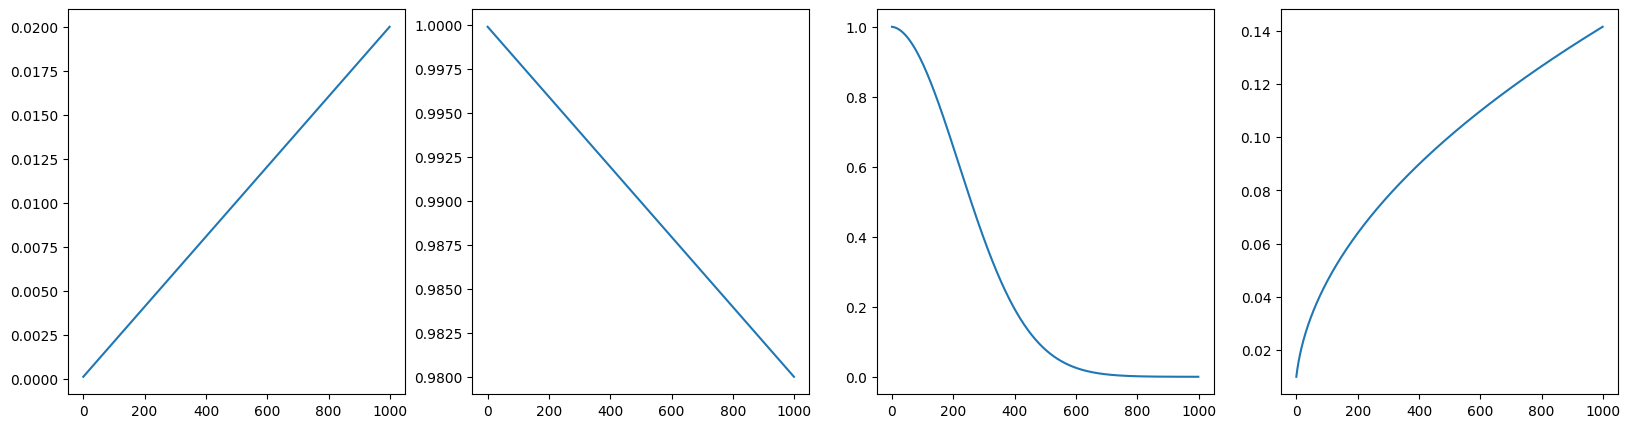

In [61]:
ddpm = DDPM()
# Create a 1x4 subplot
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot beta values
axs[0].plot(ddpm.beta)

# Plot alpha values
axs[1].plot(ddpm.alpha)

# Plot alpha_hat values
axs[2].plot(ddpm.alpha_hat)

# Plot sigma values
axs[3].plot(ddpm.sigma)

# Display the plot
plt.show()

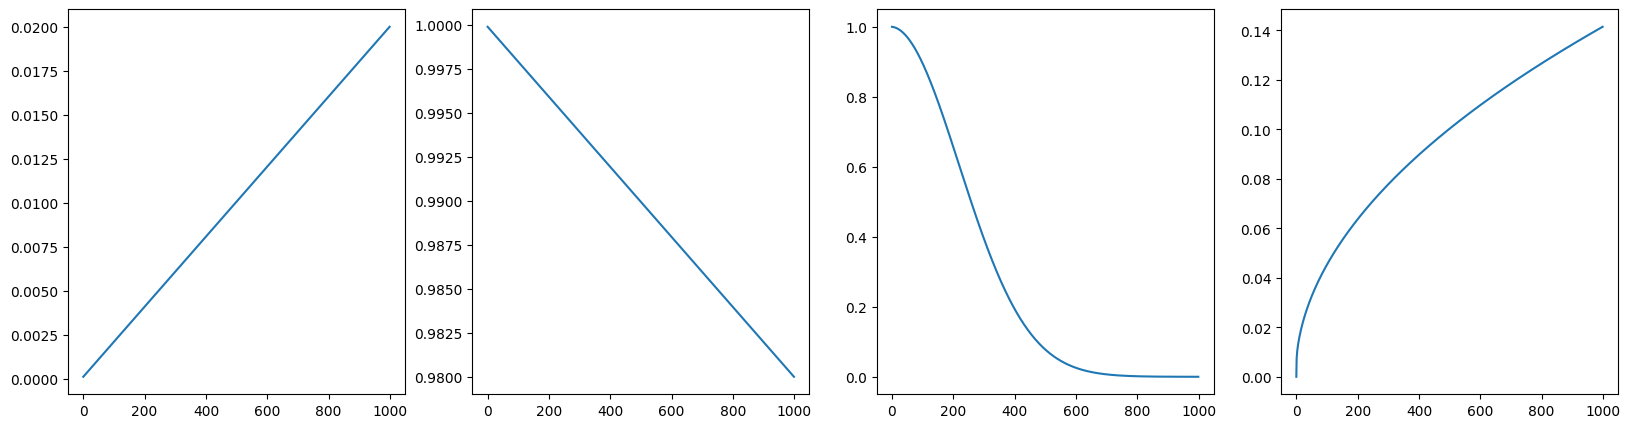

In [62]:
ddpm = DDPM(sigma='coef_bt')
# Create a 1x4 subplot
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot beta values
axs[0].plot(ddpm.beta)

# Plot alpha values
axs[1].plot(ddpm.alpha)

# Plot alpha_hat values
axs[2].plot(ddpm.alpha_hat)

# Plot sigma values
axs[3].plot(ddpm.sigma)

# Display the plot
plt.show()

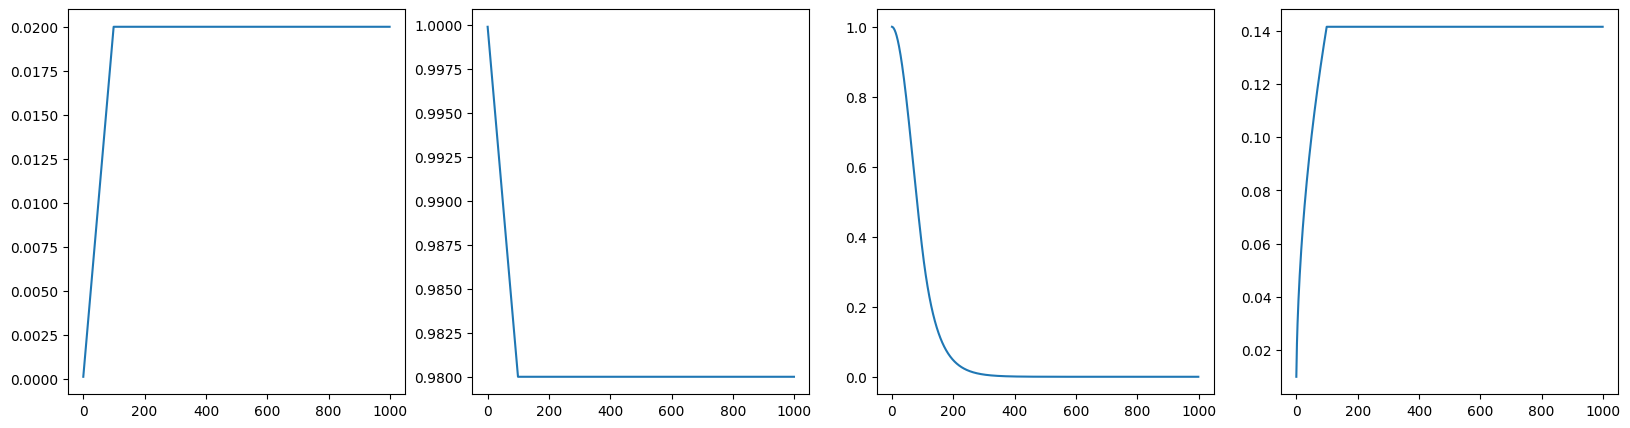

In [63]:
ddpm = DDPM(mode = 'warm0.1')
# Create a 1x4 subplot
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot beta values
axs[0].plot(ddpm.beta)

# Plot alpha values
axs[1].plot(ddpm.alpha)

# Plot alpha_hat values
axs[2].plot(ddpm.alpha_hat)

# Plot sigma values
axs[3].plot(ddpm.sigma)

# Display the plot
plt.show()

In [64]:
#export
class DDIM(DDPMBase):

    def __init__(self, beta_min=0.0001, beta_max=0.02, n_steps=1000, mode='linear', s_steps=100, s_mode='linear'):
        super().__init__(beta_min, beta_max, n_steps, mode)

        if s_mode == 'linear':
            self.inds = torch.floor(torch.linspace(0, n_steps-1, s_steps + 1)).long()
            self.prev_inds = reversed(self.inds[:-1])
            self.inds = reversed(self.inds[1:])
        else:
            raise NotImplementedError

    def update_rule(self, x_t, noise_pred, t, i, shape, device):

        t_1 = self.prev_inds[i]
        ahat_t, ahat_t1 = self.alpha_hat[t], self.alpha_hat[t_1]

        x_t = math.sqrt(ahat_t1) * ((x_t - math.sqrt(1 - ahat_t) * noise_pred) / math.sqrt(ahat_t)) + (math.sqrt(1 - ahat_t1) * noise_pred)
        
        return x_t

## Schedulers

In [8]:
#export
class SchedulerBase:

    def __init__(self, strategy:SchedulingStrategy, save_process=False):
        self.strategy = strategy
        self.save_process = save_process
    
    def get_pc(self, x_t, shape):
        # this functions receives x_t as used by the pipeline returns a cpu tensor
        return x_t.detach().cpu().reshape(shape)
        
    @torch.no_grad()
    def sample(self, model, bs, n_points=2048, nf=3, emb=None, save_process=False):
        """
            Args:
                - model        : neural net for noise prediction
                - bs           : number of samples to generate
                - n_points     : number of points per point cloud
                - nf           : number of features - default 3 for xyz coordinates
                - emb          : conditional embedding, if None it will be ignored
                - save_process : save the intermediate point clouds of the generation process
        """
        device = next(model.parameters()).device
        shape = (bs, n_points, nf)

        emb = torch.full((bs,), emb, dtype=torch.long).to(device) if emb is not None else None
        
        x_t = self.create_noise(shape, device)
        preds = [self.get_pc(x_t, shape)] 

        for i, t in enumerate(self.strategy.steps):
            x_t = self.sample_step(model, x_t, t, i, emb, shape, device)
            if save_process: preds.append(self.get_pc(x_t, shape)) 

        return preds if save_process else self.get_pc(x_t, shape)


    def sample_step(self, model, x_t, t, i, emb, shape, device):
        """
            Args:
                - model  : neural net for noise prediction
                - x_t    : previous point cloud
                - t      : current time step
                - i      : denoising iteration
                - emb    : conditional embedding, if None it will be ignored
                - shape  : shape of the point cloud
                - device : device to run the computations
        """
        bs = shape[0]

        # creating the time embedding variable
        t_batch = torch.full((bs,), t, device=device, dtype=torch.long)

        # activate the model to predict the noise
        noise_pred = model((x_t, t_batch)) if emb is None else model((x_t, t_batch, emb))
        
        # calculate the new point coordinates
        x_t = self.update_rule(x_t, noise_pred, t, i, shape, device)
        
        return x_t

    def create_noise(self, shape, device):
        return torch.randn(shape).to(device)

    @abstractmethod
    def predict_x0_from_noise(self, x_t, noise_pred, t, shape, device):
        # x_t.shape : B x N x F
        # noise_pred.shape : B x N x F
        pass
    
    @abstractmethod
    def update_rule(self, x_t, noise_pred, t, shape, device):
        # x_t.shape : B x N x F
        # noise_pred.shape : B x N x F
        pass

    @abstractmethod
    def noisify_sample(self, x0, step):
        pass

In [9]:
#export
class SparseScheduler(SchedulerBase):

    def __init__(self, strategy:SchedulingStrategy, save_process=False, pres=1e-5):
        super().__init__(strategy, save_process)
        self.pres = pres
    
    def create_noise(self, shape, device):
        noise = torch.randn(shape)
        noise = torch.clamp(noise, min=-3, max=3) # clamping the noise in [-3, 3] cube to reduce outlier points
        noise = self.torch2sparse(noise, shape).to(device)
        return noise

    def get_pc(self, x_t, shape):
        # this functions receives x_t as used by the pipeline returns a cpu tensor
        return x_t.F.detach().cpu().reshape(shape)

    def update_rule(self, x_t, noise_pred, t, i, shape, device):
        # outside the update_rule the point cloud is represented as SparseTensor
        x_t = x_t.F
        x_t = self.strategy.update_rule(x_t, noise_pred, t, i, shape, device)
        # return a SparseTensor
        return self.torch2sparse(x_t, shape).to(device)

        
    @abstractmethod
    def torch2sparse(self, pts:torch.Tensor, shape):
        # Receive a torch.Tensor of shape BxNxF and returns a SparseTensor representation
        pass

In [10]:
#export
class SparseSchedulerCPU(SparseScheduler):

    def torch2sparse(self, pts:torch.Tensor, shape):
        # Receive a torch.Tensor of shape BxNxF and returns a SparseTensor representation
        pts = pts.cpu().reshape(shape) # make sure points have the correct shape
        
        # make coordinates positive
        coords = pts[:, :, :3]
        coords = coords - coords.min(dim=1, keepdim=True)[0]
        coords = coords.numpy()

        # Unfortunately we need to loop over the batch to apply sparse_quantize 
        # Also DATA have to be in CPU and coords represented as np.arrays
        batch = []
        for b in range(shape[0]):

            c, indices = sparse_quantize(coords[b], self.pres, return_index=True)
            f = pts[b][indices]

            batch.append(
                {'pc':SparseTensor(coords = torch.tensor(c), feats=f)}
            )
        
        batch = sparse_collate_fn(batch)['pc']

        return batch

In [11]:
#export
class SparseSchedulerGPU(SparseScheduler):

    def torch2sparse(self, pts:torch.Tensor, shape):
        pts = pts.reshape(shape)
        
        coords = pts[..., :3] # In case points have additional features
        coords = coords - coords.min(dim=1, keepdim=True).values
        coords, indices = batch_sparse_quantize_torch(coords, voxel_size=self.pres, return_index=True, return_batch_index=False)
        feats = pts.view(-1, 3)[indices]

        return SparseTensor(coords=coords, feats=feats).to(coords.device)

In [12]:
#export
class DDPMSparseSchedulerCPU(SparseSchedulerCPU):
    def __init__(self, beta_min=0.0001, beta_max=0.02, n_steps=1000, mode='linear', sigma='bt', pres=1e-5, save_process=False):
        strategy = DDPM(beta_min=beta_min, beta_max=beta_max, n_steps=n_steps, mode=mode, sigma=sigma)
        super().__init__(strategy, save_process=save_process, pres=pres)

class DDPMSparseSchedulerGPU(SparseSchedulerGPU):
    def __init__(self, beta_min=0.0001, beta_max=0.02, n_steps=1000, mode='linear', sigma='bt', pres=1e-5, save_process=False):
        strategy = DDPM(beta_min=beta_min, beta_max=beta_max, n_steps=n_steps, mode=mode, sigma=sigma)
        super().__init__(strategy, save_process=save_process, pres=pres)

class DDIMSparseSchedulerCPU(SparseSchedulerCPU):
     def __init__(self, beta_min=0.0001, beta_max=0.02, n_steps=1000, s_steps=100, s_mode='linear', mode='linear', pres=1e-5, save_process=False):
        strategy = DDIM(beta_min=beta_min, beta_max=beta_max, n_steps=n_steps, mode=mode, s_steps=s_steps, s_mode=s_mode)
        super().__init__(strategy, save_process=save_process, pres=pres)

class DDIMSparseSchedulerGPU(SparseSchedulerGPU):
    def __init__(self, beta_min=0.0001, beta_max=0.02, n_steps=1000, s_steps=100, s_mode='linear', mode='linear', pres=1e-5, save_process=False):
        strategy = DDIM(beta_min=beta_min, beta_max=beta_max, n_steps=n_steps, mode=mode, s_steps=s_steps, s_mode=s_mode)
        super().__init__(strategy, save_process=save_process, pres=pres)

In [ ]:
sched = DDIMSparseSchedulerCPU()
t_start = time.time()
preds = sched.sample(model, 32)
t_end = time.time()
print(f"Generation time of {1} sample {t_end-t_start} sec")
vis_batch(preds)